# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [189]:
import numpy as np
np.random.seed(42)

In [190]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [191]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS** using the GPU


Upload the `test.csv` and `training.csv` files that you can download from campus virtual.

In [192]:
# loading data

#FTRAIN = 'training.csv'
FTRAIN = 'combined.csv'
FTEST = 'test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN

    # Option for local
    #df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # Option for Google Colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    df= read_csv('/content/drive/My Drive/_Universität_HPI/Semester 5/DeepLearning/Assignments/DeepHW 2/'+fname)



    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

Mounted at /content/drive


Number of samples in combined.csv : 4280
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:


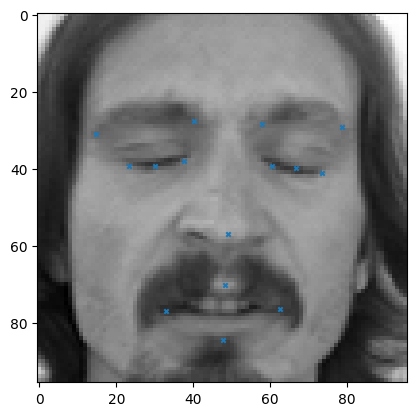

In [193]:
# loading data

X, y = load()

print("\n Sample image with labels:")
plot_sample(X[13],y[13])

In [194]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(2996, 96, 96, 1)
(642, 96, 96, 1)
(642, 96, 96, 1)


In [195]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210 (Conv2D)         (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_210 (MaxPool  (None, 48, 48, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_211 (Conv2D)         (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_211 (MaxPool  (None, 24, 24, 64)        0         
 ing2D)                                                          
                                                                 
 flatten_57 (Flatten)        (None, 36864)             0         
                                                                 
 dense_105 (Dense)           (None, 30)              

In [196]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
22/22 [==============================] - 2s 48ms/step - loss: 0.2523 - val_loss: 0.1189
Epoch 2/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0944 - val_loss: 0.0754
Epoch 3/50
22/22 [==============================] - 1s 39ms/step - loss: 0.0656 - val_loss: 0.0634
Epoch 4/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0589 - val_loss: 0.0537
Epoch 5/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0507 - val_loss: 0.0462
Epoch 6/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0451 - val_loss: 0.0475
Epoch 7/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0407 - val_loss: 0.0405
Epoch 8/50
22/22 [==============================] - 1s 43ms/step - loss: 0.0378 - val_loss: 0.0439
Epoch 9/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0354 - val_loss: 0.0411
Epoch 10/50
22/22 [==============================] - 1s 43ms/step - loss: 0.0326 - val_loss: 0.0391
Epoch 11/

In [197]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

21/21 [==============================] - 0s 4ms/step
Mean pixel error:  1.8452269


## Image Visualisations

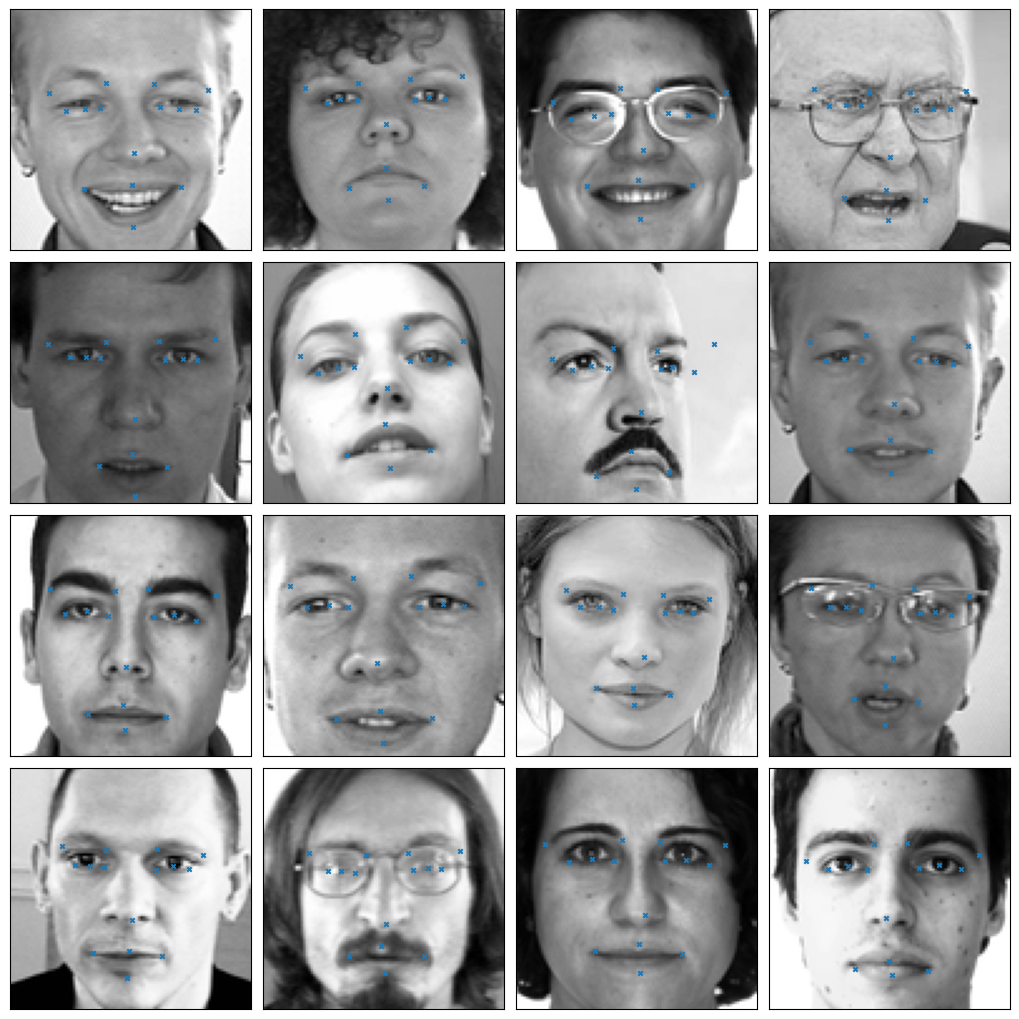

In [198]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

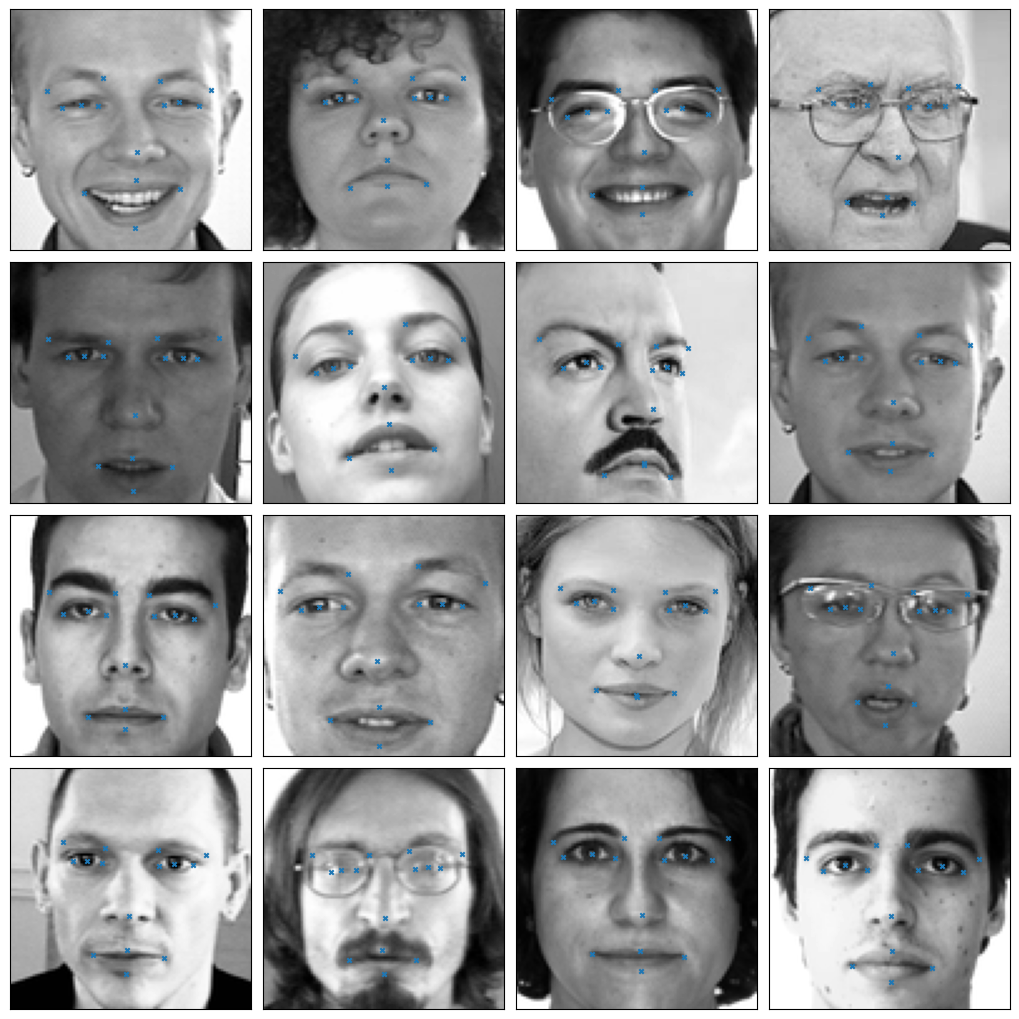

In [199]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Your solution

In [200]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [201]:
#Daten holen

X, y = load()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

Mounted at /content/drive


Number of samples in combined.csv : 4280
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']


In [204]:
model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(30))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=root_mean_squared_error, metrics=['mae'])
history = model.fit(x_train, y_train, epochs=150, batch_size=64, validation_split=0.1)

y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Epoch 1/150
43/43 [==============================] - 3s 28ms/step - loss: 0.1473 - mae: 0.1170 - val_loss: 0.0851 - val_mae: 0.0643
Epoch 2/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0921 - mae: 0.0709 - val_loss: 0.0710 - val_mae: 0.0515
Epoch 3/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0838 - mae: 0.0638 - val_loss: 0.0765 - val_mae: 0.0567
Epoch 4/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0790 - mae: 0.0599 - val_loss: 0.0688 - val_mae: 0.0500
Epoch 5/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0762 - mae: 0.0576 - val_loss: 0.0726 - val_mae: 0.0539
Epoch 6/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0735 - mae: 0.0553 - val_loss: 0.0711 - val_mae: 0.0530
Epoch 7/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0705 - mae: 0.0529 - val_loss: 0.0615 - val_mae: 0.0444
Epoch 8/150
43/43 [==============================] - 1s 20ms/step - loss: 0.

In [205]:
# Testing and First Result Reporting

y_new_test = model.predict(x_test)
print("Mean pixel error: ", rmse_pixel(y_test, y_new_test))

21/21 [==============================] - 0s 4ms/step
Mean pixel error:  1.291104


# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.3 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.291104

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**:

**The Architecture**

In my code, I employed 2D Convolutional Layers as they excel at discerning spatial patterns within input data. Alternating with these layers, I incorporated MaxPooling2D Layers for efficient pooling. I opted for the ReLU activation function for the Convolutional Layers, as it consistently yielded superior results during experimentation with various activation functions.

To process the 96x96 input data, I applied **`model.add(Flatten())`** to flatten it. To mitigate overfitting, a Dropout Layer with a dropout rate of 0.5 was introduced. Finally, a Dense Output-Layer was included to predict the 30 coordinate features.

**Compiling**

After thorough experimentation with popular optimizers like RMSProp, Adagrad, Adadelta, Adam, Adamax, Nadam, and Stochastic Gradient Descent, I settled on Adam due to its consistently superior performance. Evaluating optimizers can be challenging due to randomness and training time, making it essential to conduct statistically robust tests. The chosen loss function, **`root_mean_squared_error`**, aligns with the optimization goal. I also added Mean Absolute Error as a metric, offering an additional perspective. Extensive trials with learning rates concluded with the adoption of 0.001, yielding optimal results.

**Training**

The choice of a batch size of 64 outperformed alternatives (32 and 128), and a validation split of 0.1 was maintained. Batch size selection often involves a trade-off between computational efficiency and model performance but too small batch sizes can also lead to instability in the results. For Epochs I used in the end 150. 300 Epochs gave in average better results which were consistently on 1.30 and sometimes in the high 1.29 but only with 150 Epochs I got this result. Also the training with 500 Epochs took double the time which I usually trained with 150 Epochs. But to be optimal with a new unknown dataset or if I would want a maximaly low mean validation over time  300 Epochs would be the best, this is just the configuration with which I got this testing error.

**The Data**

To augment the dataset, I employed a technique of mirroring images along the x-axis, effectively expanding the dataset and enhancing the model's predictive capabilities. It was critical to not only transform x-values but also to swap “…left…” and “…right…” fields during mirroring, accounting for features like eyes changing sides. Failure to implement these swaps can lead to a significant increase in pixel error. Attempts to improve facial point detection using grayscale image editing, such as contrast enhancement, proved counterproductive and were omitted for the final model.